# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [1]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

Default GPU Device: /device:GPU:0


In [2]:
def download_file(url, file_path):
    import requests
    r = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(r.content)

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

dataset = 'shakespeare.txt' # Other options are mark_twain.txt, charles_dickens.txt

download_file(f'https://raw.githubusercontent.com/UofT-DSI/deep_learning/main/03_assignments/downloaded_books/' + dataset, dataset)

# Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.
text = load_dataset(dataset, fraction=0.1)

# 1. Data Preparation (10 Marks)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration (3 Marks)

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [3]:
#first 1000 characters
print(text[:1000])

The Project Gutenberg EBook of Hamlet, by William Shakespeare

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: Hamlet

Author: William Shakespeare

Editor: Charles Kean

Release Date: January 10, 2009 [EBook #27761]

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK HAMLET ***




Produced by David Starner, Curtis Weyant and the Online
Distributed Proofreading Team at https://www.pgdp.net









    Transcriber's Note:
    This is a heavily edited version of _Hamlet_. It was used
    for Charles Kean's 1859 stage production. Phrases printed
    in italics in the book are indicated in this electronic
    version by _ (underscore). Footnotes originally appeared
    at the bottom of each page. For this electronic version
    the footnotes 

In [4]:
#number of unique characters
unique_chars = len(set(text))
print("Number of unique characters:", unique_chars)

Number of unique characters: 131


In [5]:
#size of dataset
print("Dataset size:", len(text))

Dataset size: 935886


## 1.2 Text Pre-Processing (4 Marks)

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [6]:
from keras.preprocessing.text import Tokenizer

# Tokenize the text
VOCAB_SIZE = 200  # Example vocabulary size, adjust as needed
OOV_TOKEN = '<UNK>'  # Out of vocabulary token
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN, lower=True, char_level=False)
tokenizer.fit_on_texts([text])

If everything worked, the following line should show you the first 10 words in the vocabulary:

In [7]:
print(list(tokenizer.word_index.items())[:10])

[('<UNK>', 1), ('the', 2), ('and', 3), ('of', 4), ('to', 5), ('a', 6), ('in', 7), ('i', 8), ('that', 9), ('you', 10)]


## 1.3 Sequence Generation (3 Marks)

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [8]:
SEQ_LENGTH = 40 # Choose an appropriate sequence length

# Convert the text to a list of sequences of numbers
sequences = tokenizer.texts_to_sequences([text])[0]

# Generate the training sequences
X = []
y = []
for i in range(len(sequences) - SEQ_LENGTH):
    X.append(sequences[i:i + SEQ_LENGTH])
    y.append(sequences[i + SEQ_LENGTH])

Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [9]:
print(f'Sequence: {X[0]}\nTarget: {y[0]}')
print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')

Sequence: [2, 56, 54, 1, 4, 107, 28, 1, 172, 20, 1, 13, 16, 2, 176, 4, 1, 1, 33, 43, 1, 3, 14, 1, 43, 1, 1, 10, 85, 1, 15, 124, 15, 163, 29, 1, 176, 15, 1, 2]
Target: 1
Translated back to words: ['the', 'project', 'gutenberg', '<UNK>', 'of', 'hamlet', 'by', '<UNK>', 'shakespeare', 'this', '<UNK>', 'is', 'for', 'the', 'use', 'of', '<UNK>', '<UNK>', 'at', 'no', '<UNK>', 'and', 'with', '<UNK>', 'no', '<UNK>', '<UNK>', 'you', 'may', '<UNK>', 'it', 'give', 'it', 'away', 'or', '<UNK>', 'use', 'it', '<UNK>', 'the'] -> <UNK>


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [10]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
mask = y != tokenizer.word_index[OOV_TOKEN]
X = X[mask]
y = y[mask]

# One-hot encode the target token
y = to_categorical(y, num_classes=VOCAB_SIZE)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (70996, 40)
y_train shape: (70996, 200)


# 2. Model Development (10 Marks)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture (4 Marks)

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential([
    # Your code here
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=VOCAB_SIZE),
    LSTM(256),
    Dense(VOCAB_SIZE, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2643800   
                                                                 
 lstm (LSTM)                 (None, 256)               467968    
                                                                 
 dense (Dense)               (None, 200)               51400     
                                                                 
Total params: 3163168 (12.07 MB)
Trainable params: 3163168 (12.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 2.2 Model Compilation (3 Marks)

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

_Selected Adam optimizer for its ease of use and efficiencies. Provided better results that others. The loss function is set to 'categorical crossentropy' because targets are one-hot encoded which simplifies data paraation._

In [12]:
# Your code here
from tensorflow.keras.optimizers import Adam
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

## 2.3 Model Training (3 Marks)

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [13]:
# Your code here
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_val,y_val))

Epoch 1/5
555/555 [==============================] - 19s 17ms/step - loss: 4.0029 - accuracy: 0.1525 - val_loss: 3.7541 - val_accuracy: 0.1817
Epoch 2/5
555/555 [==============================] - 7s 12ms/step - loss: 3.6359 - accuracy: 0.1916 - val_loss: 3.6808 - val_accuracy: 0.1901
Epoch 3/5
555/555 [==============================] - 6s 11ms/step - loss: 3.5246 - accuracy: 0.2061 - val_loss: 3.6398 - val_accuracy: 0.1976
Epoch 4/5
555/555 [==============================] - 6s 11ms/step - loss: 3.4417 - accuracy: 0.2180 - val_loss: 3.6248 - val_accuracy: 0.2019
Epoch 5/5
555/555 [==============================] - 6s 10ms/step - loss: 3.3804 - accuracy: 0.2252 - val_loss: 3.6363 - val_accuracy: 0.2050


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

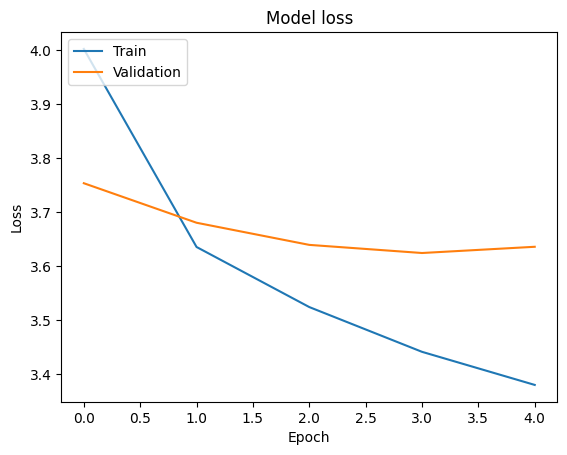

In [14]:
import matplotlib.pyplot as plt

# Your code here

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 3. Text Generation (10 Marks)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [15]:
from keras.preprocessing.sequence import pad_sequences

def get_predicted_word(model, sequence):
    """
    Get the predicted word from the model.
    This helper function uses a concept we haven't covered in class yet: temperature.
    In essence, a little bit of randomness in what word we predict can make the text more interesting.
    """

    # Use the model to predict the next token in the sequence
    yhat = model.predict(sequence, verbose=0)

    # Get the index of the predicted word, according to the probabilities
    yhat = np.random.choice(range(VOCAB_SIZE), p=yhat.ravel())

    return yhat

def generate_text(model, tokenizer, seed_text, max_sequence_len):
    """
    Generate new text using the trained model.
    You can use the `get_predicted_word` helper function to help you with this.
    """

    result = seed_text
    # Tokenize the seed text
    seed = tokenizer.texts_to_sequences([seed_text])[0]

    for _ in range(max_sequence_len):
        # Pad the sequence
        padded = pad_sequences([seed], maxlen=max_sequence_len, padding='pre')

        # Get the predicted word index
        predicted_word_index = get_predicted_word(model, padded)

        # Convert index to word
        predicted_word = tokenizer.index_word[predicted_word_index]

        # Add the predicted word to the result
        result += ' ' + predicted_word

        # Update the seed for next iteration
        seed.append(predicted_word_index)

    return result


In [16]:
# Test the text generation function
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

'hamlet have my lord the man too much of your daughter could not speak i not take thee if you had not only the first queen and the it shall be there to his own this and the old and as'

It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small.

# 4. Model Refinement (5 Marks)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras.
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [17]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2024-05-15 04:03:25--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.89MB/s    in 2m 42s  

2024-05-15 04:06:08 (5.09 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [18]:
# Load the pre-trained embeddings
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


In [19]:
# Create an embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [20]:
embedding_layer = Embedding(
    VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False
)

In [22]:
# Define a new model and train it

# Your code here

import numpy as np
from keras.layers import Embedding

# Load the GloVe embeddings
embeddings_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create an embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Modify your model to use the pre-trained embeddings
embedding_layer = Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False)

# Update your model architecture to use the embedding layer
model = Sequential([
    embedding_layer,
    LSTM(256, return_sequences=True),
    LSTM(256),
    Dense(VOCAB_SIZE, activation='softmax')
])


In [24]:
from tensorflow.keras.optimizers import Adam
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [25]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_val,y_val))

Epoch 1/5
555/555 [==============================] - 15s 18ms/step - loss: 4.1053 - accuracy: 0.1386 - val_loss: 3.8146 - val_accuracy: 0.1713
Epoch 2/5
555/555 [==============================] - 10s 18ms/step - loss: 3.6907 - accuracy: 0.1824 - val_loss: 3.7013 - val_accuracy: 0.1844
Epoch 3/5
555/555 [==============================] - 10s 18ms/step - loss: 3.5578 - accuracy: 0.2013 - val_loss: 3.6438 - val_accuracy: 0.1882
Epoch 4/5
555/555 [==============================] - 9s 16ms/step - loss: 3.4526 - accuracy: 0.2152 - val_loss: 3.5992 - val_accuracy: 0.2030
Epoch 5/5
555/555 [==============================] - 11s 21ms/step - loss: 3.3502 - accuracy: 0.2305 - val_loss: 3.5823 - val_accuracy: 0.2058


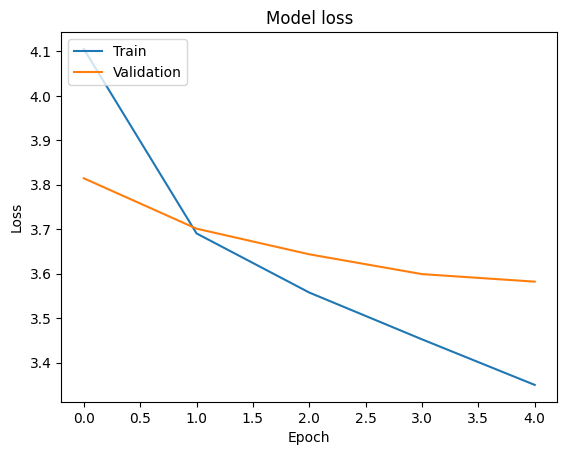

In [26]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()